In [156]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [157]:
NUM_RUNS = 1

A = 16      # dimension of each hidden layer
B = 3       # number of hidden layers
C = 0.01    # stochastic gradient descent learning rate
D = 1500      # maximum numbers of transitions stored by replay buffer
E = 300     # number of episodes of learning running the task
F = 0.33     # epsilon probability of eps-greedy policy
G = 0.83    # reward discounting factor
H = 50      # replay buffer sample size
I = 20      # The interval between two consecutive target network update

In [ ]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    # layers = [4] + [A]*B + [2]
    layers = [4] + [16, 32, 8] + [2]
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=C, weight_decay=0.1)
    memory = ReplayBuffer(D)

    steps_done = 0
    episode_durations = []

    for i_episode in range(E):            
        if (i_episode+1) % 30 == 0:
            print("episode ", i_episode+1, "/", 300)
            optimizer.param_groups[0]["lr"] *= 0.5
            I = int(I*1.5)
            
        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(F, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])/G
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < H:
                transitions = memory.sample(H)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
            steps_done += 1
            # Update the target network, copying all weights and biases in DQN
            if steps_done % I == 0: 
                update_target(target_net, policy_net)

    runs_results.append(episode_durations)
print('Complete', steps_done)

Starting run 1 of 1
episode  30 / 300
episode  60 / 300
episode  90 / 300
episode  120 / 300
episode  150 / 300
episode  180 / 300
episode  210 / 300
episode  240 / 300
episode  270 / 300
episode  300 / 300
Complete 16167


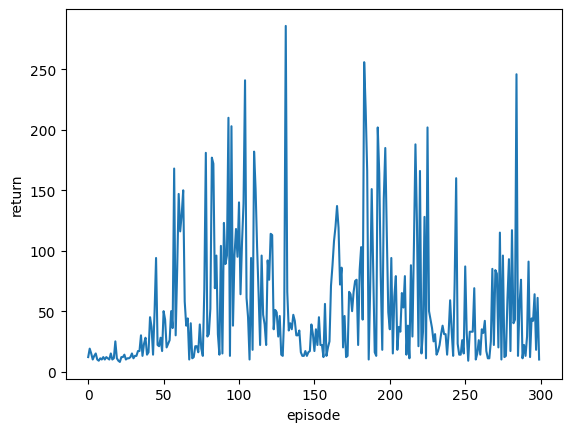

In [159]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

num_episodes = len(runs_results[0])
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(num_episodes), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
plt.show()

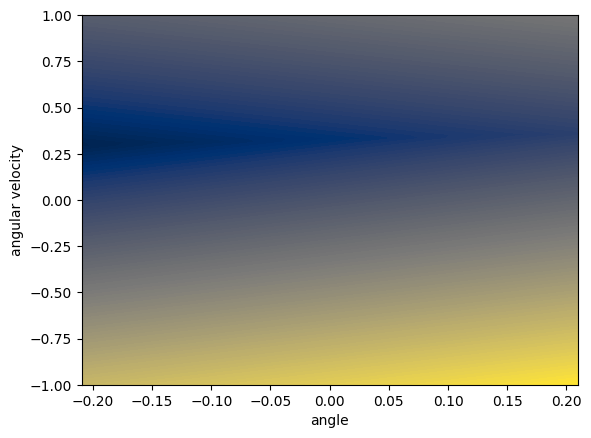

In [160]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can freely modify these plots and code

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()